In [1]:
#####Rank logit model#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import seaborn as sns
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no, pattern):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    if pattern==1:
        Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
        return z_id, Z
    return z_id

In [3]:
##データの設定
r = 3   #3位まで選択
n = 50000   #ユーザー数
member = 10   #選択可能数
N = member*n   #総レコード数

In [4]:
##idとインデックスの設定
#idの設定
user_id = np.repeat(np.arange(n), np.repeat(member, n))
member_id = np.tile(np.arange(member), n)

#インデックスの設定
user_list = [i for i in range(n)]
member_list = [j for j in range(member)]
for i in range(n):
    user_list[i] = np.array(np.where(user_id==i)[0], dtype="int")
for j in range(member):
    member_list[j] = np.array(np.where(member_id==j)[0], dtype="int")

In [5]:
##説明変数の生成
#衣装タイプの生成
types = 9   #衣装数
CLOTH = np.zeros((N, types), dtype="int")
Prob = np.random.dirichlet(np.repeat(2.0, types), 1).reshape(-1)
for j in range(member):
    CLOTH[member_list[j], ] = np.random.multinomial(1, Prob, n)
CLOTH = CLOTH[:, np.delete(np.arange(types), np.argmin(np.sum(CLOTH, axis=0)))]

#メンバーのshare of voiceを生成
alpha = np.abs(np.random.normal(0, 0.5, member))
AWARE = np.random.dirichlet(alpha, n).reshape(-1)

#メンバーの接触確率を生成
alpha = np.abs(np.random.normal(0, 0.5, member))
CONTACT = np.random.dirichlet(alpha, n).reshape(-1)

#登録からの経過年数
REGIST = np.abs(np.random.normal(0, 1.0, n))

#プレイ時間の対数
PLAY = np.abs(np.random.normal(0, 1.0, n))

#データの結合
x1 = np.hstack((np.repeat(1, n)[:, np.newaxis], REGIST[:, np.newaxis], PLAY[:, np.newaxis]))
x2 = np.hstack((CLOTH, AWARE[:, np.newaxis], CONTACT[:, np.newaxis]))
k1 = x1.shape[1]
k2 = x2.shape[1]
k = k1*(member-1) + k2

In [6]:
##応答変数の生成
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    #パラメータの設定
    beta01 = np.random.multivariate_normal(np.repeat(0.75, member-1), np.diag(np.repeat(1.5, member-1)), 1).reshape(-1)
    beta02 = np.random.multivariate_normal(np.repeat(0.0, member-1), np.diag(np.repeat(0.25, member-1)), 1).reshape(-1)
    beta03 = np.random.multivariate_normal(np.repeat(0.0, member-1), np.diag(np.repeat(0.25, member-1)), 1).reshape(-1)
    beta11 = np.random.multivariate_normal(np.repeat(0.0, types-1), np.diag(np.repeat(1.0, types-1)), 1).reshape(-1)
    beta12 = np.array([0.75])
    beta13 = np.array([1.0])
    beta1 = np.vstack((beta01, beta02, beta03))
    beta2 = np.concatenate((beta11, beta12, beta13))
    betat1 = beta1.copy(); betat2 = beta2.copy() 
    betat = np.append(betat1.reshape(-1), beta2)
    
    #潜在効用を定義
    Util1 = np.hstack((np.dot(x1, beta1), np.repeat(0, n)[:, np.newaxis]))
    Util2 = np.dot(x2, beta2).reshape(n, member)
    Util = np.exp(Util1 + Util2)

    #ランキングを生成
    rank = np.zeros((n, r), dtype="int")
    Rank = np.zeros((n, member, r), dtype="int")
    Prob = np.zeros((n, member, r))
    Z = np.full((n, member, r), 1)

    for j in range(r):
        #選択済みメンバーのflagを削除
        if j >= 1:
            Z[:, :, j] = Z[:, :, j-1] * (1-Rank[:, :, j-1])

        #順位ごとの選択確率を定義
        U = Util * Z[:, :, j]
        Prob[:, :, j] = U / np.sum(U, axis=1)[:, np.newaxis]

        #多項分布から順位を生成
        res = rmnom(Prob[:, :, j], n, member, np.arange(n), 1)
        Rank[:, :, j] = np.array(res[1].todense(), dtype="int")
        rank[:, j] = np.array(res[0], dtype="int")
        
    #break条件
    if np.median(np.max(Prob[:, :, 0], axis=1)) > 0.55:
        break

1
2
3
4
5
6
7
8
9
10


[[ 5674  1613   124 25903   190  1581  1207 11465   907  1336]
 [ 9032  3405   297 12239   505  3568  2507 13421  2124  2902]
 [ 9714  5266   584  6476   961  5486  3771  9201  3775  4766]]
[[0.113 0.032 0.002 0.518 0.004 0.032 0.024 0.229 0.018 0.027]
 [0.181 0.068 0.006 0.245 0.01  0.071 0.05  0.268 0.042 0.058]
 [0.194 0.105 0.012 0.13  0.019 0.11  0.075 0.184 0.076 0.095]]


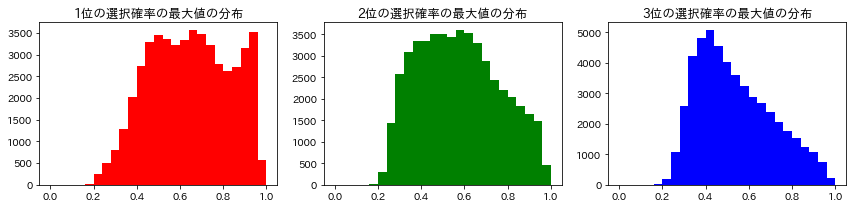

In [7]:
#生成したデータの集計と可視化
print(np.sum(Rank, axis=0).T)
print(np.round(np.sum(Rank, axis=0).T / n, 3))

fig_range = np.append(np.array([0, 0, 0]), np.array([1.0, 1.0, 1.0])).reshape(2, r)
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["1位の選択確率の最大値の分布", "2位の選択確率の最大値の分布", "3位の選択確率の最大値の分布"]
fig = plt.figure(figsize=(12.0, 3.0))
for j in range(r):
    ax = fig.add_subplot(1, 3, j+1)
    ax.hist(np.max(Prob[:, :, j], axis=1),  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [8]:
####最尤法でパラメータを推定####
##Rank Logit modelのパラメータを推定するための関数
#対数尤度関数を定義
def loglike(beta, Rank, Z, x1, x2, r, member, n, k1, k2, k, index_para):
    #パラメータの設定
    index = index_para.T.reshape(-1)
    beta1 = beta[index].reshape(k1, member-1)
    beta2 = beta[np.delete(np.arange(k), index)]

    #潜在効用を定義
    Util1 = np.hstack((np.dot(x1, beta1), np.repeat(0, n)[:, np.newaxis]))
    Util2 = np.dot(x2, beta2).reshape(n, member)
    Util = np.exp(Util1 + Util2)

    #順位ごとの対数尤度の和
    LL = np.array([0.0])
    for j in range(r):
        #選択確率を定義
        U = Util * Z[:, :, j]
        Prob = U / np.sum(U, axis=1)[:, np.newaxis]

        #対数尤度の和
        LL += np.sum(np.log(np.sum(Rank[:, :, j] * Prob, axis=1)))
    return -LL

#勾配ベクトルの和を定義
def dloglike(beta, Rank, Z, x1, x2, r, member, n, k1, k2, k, index_para):
    #パラメータの設定
    target = np.arange(member-1)
    index = index_para.T.reshape(-1)
    beta1 = beta[index].reshape(k1, member-1)
    beta2 = beta[np.delete(np.arange(k), index)]

    #潜在効用を定義
    Util1 = np.hstack((np.dot(x1, beta1), np.repeat(0, n)[:, np.newaxis]))
    Util2 = np.dot(x2, beta2).reshape(n, member)
    Util = np.exp(Util1 + Util2)

    #順位ごとの勾配ベクトルを定義
    dlogit = np.repeat(0.0, k)
    for j1 in range(r):
        #選択確率を定義
        U = Util * Z[:, :, j1]
        Prob = U / np.sum(U, axis=1)[:, np.newaxis]

        #勾配ベクトルの和を定義
        er_rank = Rank[:, :, j1] - Prob; er_target = er_rank[:, target]
        dlogit1 = np.repeat(0.0, k1*(member-1))
        for j2 in range(r):
            dlogit1[index_para[:, j2]] = np.sum(er_target * x1[:, j2][:, np.newaxis], axis=0)
        dlogit2 = np.sum((er_rank.reshape(-1))[:, np.newaxis] * x2, axis=0)
        dlogit += np.append(dlogit1, dlogit2)
    return -dlogit

In [9]:
##準ニュートン法で対数尤度を最大化
#初期値の設定
index_para = np.arange(k1*(member-1)).reshape(member-1, k1, order="F")
beta = np.repeat(0.0, k)

#対数尤度を最大化
res = optimize.minimize(loglike, beta, jac=dloglike, method="BFGS", args=(Rank, Z, x1, x2, r, member, n, k1, k2, k, index_para),
                        options={"gtol": 0.01, "disp":True})

Optimization terminated successfully.
         Current function value: 173696.039617
         Iterations: 65
         Function evaluations: 82
         Gradient evaluations: 82


In [10]:
##推定されたパラメータの確認と適合度
#適合度の確認
LL = -res.fun   #最大化された対数尤度
LLbest = -loglike(betat, Rank, Z, x1, x2, r, member, n, k1, k2, k, index_para) 
AIC = -2*LL + 2*k   #AIC
BIC = -2*LL + np.log(n)*k   #BIC
print(np.round(np.append(LL, LLbest), 1))
print(np.round(np.array([LL, AIC, BIC]), 3))

[-173696.  -173713.2]
[-173696.04   347466.079  347792.411]


In [11]:
#推定されたパラメータと真のパラメータの比較
beta = res.x   #推定されたパラメータ
hessian = res.hess_inv   #ヘッシアンの逆行列
t_value = beta / np.sqrt(np.diag(hessian))   #t値
pd.DataFrame({"推定されたパラメータ": beta, "パラメータの真値": betat, "t値": t_value})

,推定されたパラメータ,パラメータの真値,t値
0,2.574770,2.573773,87.133599
1,-0.499609,-0.560865,-15.502238
2,-1.360506,-1.454939,-22.003405
3,4.123468,4.110061,138.845309
4,-1.654718,-1.718562,-34.107556
5,1.018109,1.042965,32.381983
6,-1.396787,-1.393752,-39.481779
7,2.841060,2.831824,96.994043
8,0.252247,0.277274,7.373498
9,-0.070123,-0.095046,-2.966629
